## 📅 Day 6: Full Training Flow

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch.utils.data import TensorDataset

In [4]:
# - Train on a small real dataset 
adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame
y = (df["class"] == ">50K").astype(int).to_numpy()
X = df.drop(columns=["class"])

In [ ]:
# features
cat = X.select_dtypes(include=["object", "category"]).columns.tolist()
num = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat+num

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [91]:
num.remove('fnlwgt')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training sample size= {y_train.shape[0]}, Test sample size={y_test.shape[0]}")

Training sample size= 39073, Test sample size=9769


In [92]:
# Preprocess
prep = ColumnTransformer([
    ("num", StandardScaler(), num),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat),
])
pipe = Pipeline([("prep", prep)])
Xtr = pipe.fit_transform(X_train)
Xte = pipe.transform(X_test)

In [93]:
len(pipe.get_feature_names_out()), pipe.get_feature_names_out()[:10]

(107,
 array(['num__age', 'num__education-num', 'num__capital-gain',
        'num__capital-loss', 'num__hours-per-week',
        'cat__workclass_Federal-gov', 'cat__workclass_Local-gov',
        'cat__workclass_Never-worked', 'cat__workclass_Private',
        'cat__workclass_Self-emp-inc'], dtype=object))

In [94]:
type(Xtr), type(Xtr.toarray())

(scipy.sparse._csr.csr_matrix, numpy.ndarray)

In [95]:
#  To tensors & loaders
Xtr_t = torch.tensor(Xtr.toarray(), dtype=torch.float32)
Xte_t = torch.tensor(Xte.toarray(), dtype=torch.float32)
ytr_t = torch.tensor(y_train, dtype=torch.float32)
yte_t = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=128, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=512, shuffle=False)


In [97]:
class SingleResidualBlock(nn.Module):
    def __init__(self, in_dim=108, hidden_dim=16, dropout=0.0, scale=1.0):
        super().__init__()
        self.scale = scale
        # post norm
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, in_dim)
        )
    
    def forward(self, x):
        h = self.layers(x)
        y = h * self.scale + x
        return y

class MultiResidualBlock(nn.Module):
    def __init__(self, n_blocks=4, working_dim=256, in_dim=108, hidden_dim=512, final_dim=1, dropout=0.0, scale=1.0):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Linear(in_dim, working_dim, bias=False),
            nn.LayerNorm(working_dim),
            nn.ReLU()
        )
        self.blocks = nn.ModuleList([SingleResidualBlock(working_dim, hidden_dim, dropout, scale) for _ in range(n_blocks)])
        self.head = nn.Sequential(
            nn.LayerNorm(working_dim),
            nn.Linear(working_dim, final_dim)
        )

    def forward(self, x):
        h = self.stem(x)
        for block in self.blocks:
            h = block(h)
        y = self.head(h)
        return y


In [98]:
def train_epoch(dataloader, model, optimizer, criterion):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        X = X.float()
        y = y.float().view(-1)
        pred = model(X).squeeze(1)
        loss = criterion(pred, y)
        batch_size = y.shape[0]
        total_loss += loss.item()*batch_size
        total_correct += ((torch.sigmoid(pred)>=0.5).float()==y).sum().item()
        total_examples += batch_size
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * dataloader.batch_size + batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return total_loss/total_examples, total_correct/total_examples


In [99]:
def eval_epoch(dataloader, model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.float()
            y = y.float().view(-1)
            pred = model(X).squeeze(1)
            loss = criterion(pred, y)
            batch_size = y.shape[0]
            total_loss += loss.item() * batch_size
            total_correct += ((torch.sigmoid(pred)>=0.5).float()==y).sum().item()
            total_examples += batch_size
    total_loss /= total_examples
    total_correct /= total_examples            
    print(f"Test loss: {total_loss:>7f}  | test accuracy: {total_correct:>5f}")
    return total_loss, total_correct

In [100]:
pos_weight = torch.tensor([(len(ytr_t)-ytr_t.sum())/ytr_t.sum()], dtype=torch.float32)
pos_weight

tensor([3.1794])

In [22]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    history: dict containing lists per epoch
      e.g. {"train_loss": [...], "val_loss": [...], "train_acc": [...], "val_acc": [...]}
    """

    epochs = range(1, len(history["train_loss"]) + 1)

    # --- Loss plot ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Accuracy plot (optional) ---
    if "train_acc" in history and "val_acc" in history:
        plt.figure(figsize=(6,4))
        plt.plot(epochs, history["train_acc"], label="Train Acc")
        plt.plot(epochs, history["val_acc"], label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training vs Validation Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

In [101]:
def train_evaluate(Xtr_t, Xte_t, ytr_t, yte_t, epochs=25, lr=1e-3, n_blocks=4, working_dim=64, hidden_dim=512, dropout=0.0, scale=1.0, train_batch_size=128, sample_weight=True):
    train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=train_batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=512, shuffle=False)
    model = MultiResidualBlock(n_blocks=n_blocks, in_dim=Xtr_t.shape[1], working_dim=working_dim, hidden_dim=hidden_dim,
                                dropout=dropout, scale=scale)
    if sample_weight:
        pos_weight = torch.tensor([(len(ytr_t)-ytr_t.sum())/ytr_t.sum()], dtype=torch.float32)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    else:
        criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs)
    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(train_loader, model, optimizer, criterion)
        val_loss, val_acc = eval_epoch(val_loader, model, criterion)
        # scheduler.step()
        lr_now = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}, LR={lr_now}")
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
    
    plot_training_curves(history)
    return model


loss: 0.984790  [  128/39073]
loss: 0.827335  [12928/39073]
loss: 0.527105  [25728/39073]
loss: 0.748794  [38528/39073]
Test loss: 0.569975  | test accuracy: 0.825366
Epoch 0, LR=0.001
loss: 0.411441  [  128/39073]
loss: 0.630231  [12928/39073]
loss: 0.519827  [25728/39073]
loss: 0.533325  [38528/39073]
Test loss: 0.567013  | test accuracy: 0.819122
Epoch 1, LR=0.001
loss: 0.639629  [  128/39073]
loss: 0.718662  [12928/39073]
loss: 0.473460  [25728/39073]
loss: 0.520359  [38528/39073]
Test loss: 0.576904  | test accuracy: 0.786672
Epoch 2, LR=0.001
loss: 0.444420  [  128/39073]
loss: 0.500977  [12928/39073]
loss: 0.591789  [25728/39073]
loss: 0.472043  [38528/39073]
Test loss: 0.574293  | test accuracy: 0.820555
Epoch 3, LR=0.001
loss: 0.675300  [  128/39073]
loss: 0.877307  [12928/39073]
loss: 0.458133  [25728/39073]
loss: 0.530095  [38528/39073]
Test loss: 0.565508  | test accuracy: 0.808988
Epoch 4, LR=0.001
loss: 0.577215  [  128/39073]
loss: 0.478896  [12928/39073]
loss: 0.481180 

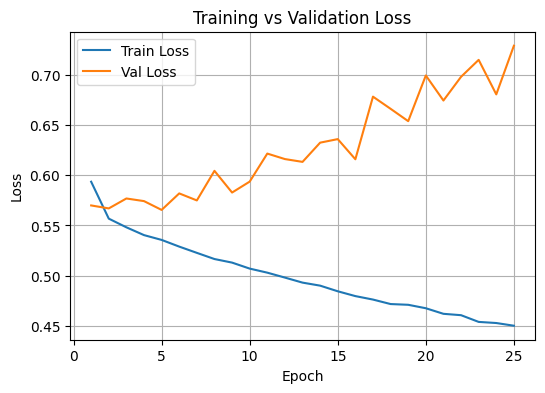

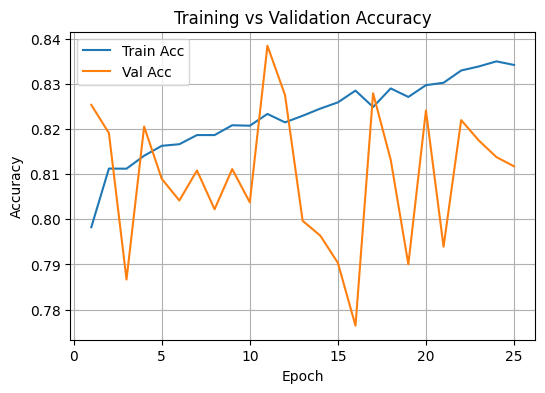

In [102]:
trained_model = train_evaluate(Xtr_t, Xte_t, ytr_t, yte_t, hidden_dim=64)

In [83]:
# - Save model with torch.save and reload
torch.save(trained_model.state_dict(), 'model_weights.pth')

In [85]:
model2 = MultiResidualBlock(working_dim=64, hidden_dim=64) # create untrained model
model2.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model2.eval()

MultiResidualBlock(
  (stem): Sequential(
    (0): Linear(in_features=108, out_features=64, bias=False)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (blocks): ModuleList(
    (0-3): 4 x SingleResidualBlock(
      (layers): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=False)
        (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (2): ReLU()
        (3): Dropout(p=0.0, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
      )
    )
  )
  (head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)

loss: 1.232210  [  128/39073]
loss: 0.529751  [12928/39073]
loss: 0.444652  [25728/39073]
loss: 0.576229  [38528/39073]
Test loss: 0.570227  | test accuracy: 0.789845
Epoch 0, LR=0.001
loss: 0.599117  [  128/39073]
loss: 0.558019  [12928/39073]
loss: 0.595227  [25728/39073]
loss: 0.706649  [38528/39073]
Test loss: 0.577532  | test accuracy: 0.772341
Epoch 1, LR=0.001
loss: 0.679316  [  128/39073]
loss: 0.563991  [12928/39073]
loss: 0.372739  [25728/39073]
loss: 0.452101  [38528/39073]
Test loss: 0.562696  | test accuracy: 0.825161
Epoch 2, LR=0.001
loss: 0.710217  [  128/39073]
loss: 0.721908  [12928/39073]
loss: 0.502938  [25728/39073]
loss: 0.568478  [38528/39073]
Test loss: 0.557560  | test accuracy: 0.820657
Epoch 3, LR=0.001
loss: 0.454301  [  128/39073]
loss: 0.493044  [12928/39073]
loss: 0.575264  [25728/39073]
loss: 0.579493  [38528/39073]
Test loss: 0.561858  | test accuracy: 0.814311
Epoch 4, LR=0.001
loss: 0.437095  [  128/39073]
loss: 0.548275  [12928/39073]
loss: 0.507700 

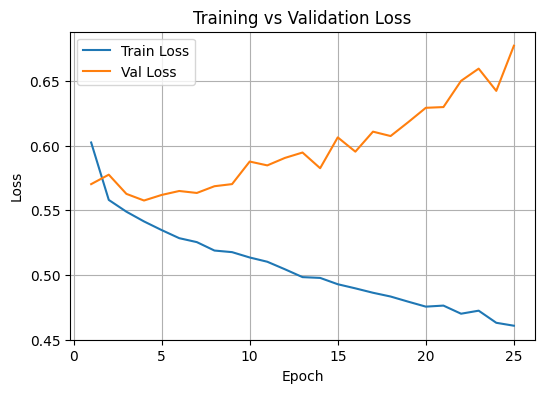

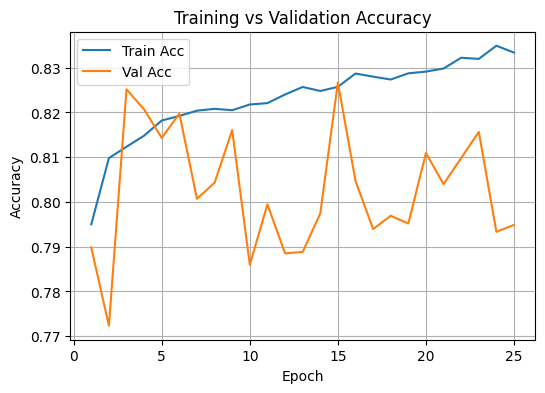

In [103]:
# - Try changing hidden size
trained_model_hidden_S = train_evaluate(Xtr_t, Xte_t, ytr_t, yte_t, hidden_dim=16)

loss: 1.115119  [  128/39073]
loss: 0.482224  [12928/39073]
loss: 0.678354  [25728/39073]
loss: 0.608850  [38528/39073]
Test loss: 0.574536  | test accuracy: 0.812366
Epoch 0, LR=0.001
loss: 0.492449  [  128/39073]
loss: 0.410290  [12928/39073]
loss: 0.603272  [25728/39073]
loss: 0.590433  [38528/39073]
Test loss: 0.573075  | test accuracy: 0.822602
Epoch 1, LR=0.001
loss: 0.512696  [  128/39073]
loss: 0.573421  [12928/39073]
loss: 0.495114  [25728/39073]
loss: 0.676520  [38528/39073]
Test loss: 0.565159  | test accuracy: 0.811240
Epoch 2, LR=0.001
loss: 0.470126  [  128/39073]
loss: 0.501768  [12928/39073]
loss: 0.557529  [25728/39073]
loss: 0.510060  [38528/39073]
Test loss: 0.567332  | test accuracy: 0.805712
Epoch 3, LR=0.001
loss: 0.528536  [  128/39073]
loss: 0.669259  [12928/39073]
loss: 0.542897  [25728/39073]
loss: 0.657609  [38528/39073]
Test loss: 0.562182  | test accuracy: 0.813696
Epoch 4, LR=0.001
loss: 0.491638  [  128/39073]
loss: 0.605454  [12928/39073]
loss: 0.610892 

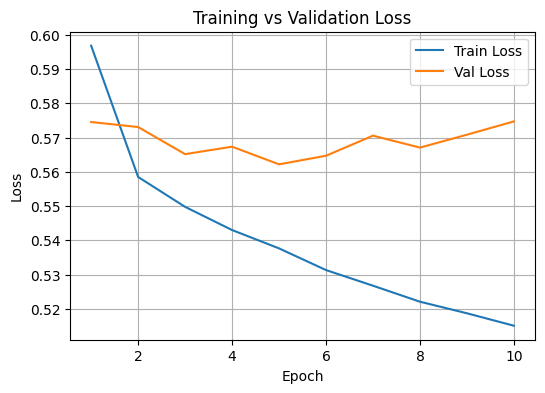

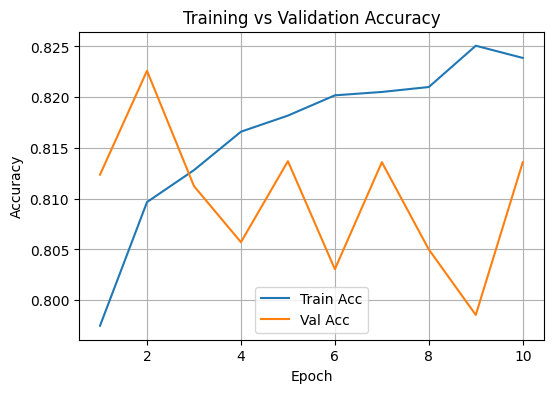

In [104]:
trained_model_oneblock = train_evaluate(Xtr_t, Xte_t, ytr_t, yte_t, epochs=10, lr=0.001, n_blocks=1, hidden_dim=16)

loss: 1.092180  [  128/39073]
loss: 0.568364  [12928/39073]
loss: 0.549947  [25728/39073]
loss: 0.606260  [38528/39073]
Test loss: 0.593095  | test accuracy: 0.811547
Epoch 0, LR=0.001
loss: 0.678970  [  128/39073]
loss: 0.455016  [12928/39073]
loss: 0.688213  [25728/39073]
loss: 0.577256  [38528/39073]
Test loss: 0.581855  | test accuracy: 0.794964
Epoch 1, LR=0.001
loss: 0.579314  [  128/39073]
loss: 0.639776  [12928/39073]
loss: 0.420832  [25728/39073]
loss: 0.448256  [38528/39073]
Test loss: 0.574637  | test accuracy: 0.795987
Epoch 2, LR=0.001
loss: 0.490084  [  128/39073]
loss: 0.662566  [12928/39073]
loss: 0.525388  [25728/39073]
loss: 0.573910  [38528/39073]
Test loss: 0.565266  | test accuracy: 0.803460
Epoch 3, LR=0.001
loss: 0.420577  [  128/39073]
loss: 0.541360  [12928/39073]
loss: 0.470316  [25728/39073]
loss: 0.442703  [38528/39073]
Test loss: 0.570941  | test accuracy: 0.826083
Epoch 4, LR=0.001
loss: 0.651125  [  128/39073]
loss: 0.444081  [12928/39073]
loss: 0.511318 

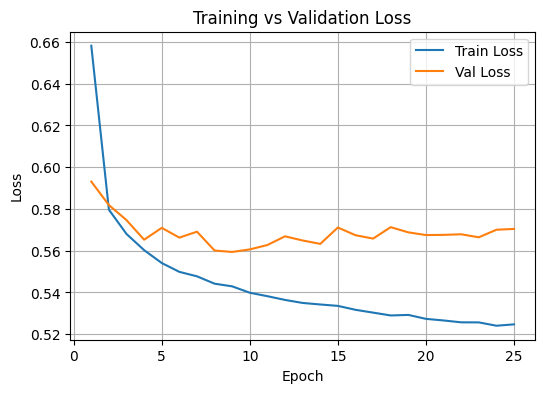

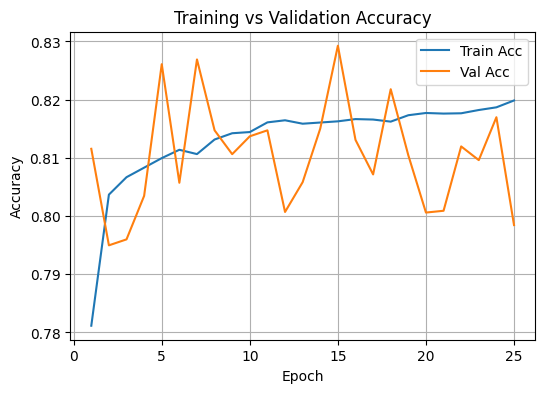

In [105]:
# - Add dropout and compare performance
trained_model_drop = train_evaluate(Xtr_t, Xte_t, ytr_t, yte_t, n_blocks=1, working_dim=16, hidden_dim=8, dropout=0.5)